In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt


In [24]:
    
# import zip file with csv 
ou_zip = zipfile.ZipFile('../data/anonymisedData.zip') 

# save separate csvs
registrations = pd.read_csv(ou_zip.open('studentRegistration.csv'))
courses = pd.read_csv(ou_zip.open('courses.csv'))
students = pd.read_csv(ou_zip.open('studentInfo.csv'))
student_vle = pd.read_csv(ou_zip.open('studentVle.csv'))
vle = pd.read_csv(ou_zip.open('vle.csv'))
student_assessments = pd.read_csv(ou_zip.open('studentAssessment.csv'))
assessments = pd.read_csv(ou_zip.open('assessments.csv'))

# check basic file properties - each file

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


def csv_basics(df, exclude_columns=None, box=True):
    '''
    Function which takes dataframe and returns basic details - rows, cols, missing vals, summary stats, and optional boxplots. 
    Option to exclude columns.
    '''

    if exclude_columns:
        df = df.drop(exclude_columns, axis=1)

    num_rows = df.shape[0]
    num_columns = df.shape[1]
    print("Number of rows:", num_rows, "\n")
    print("Number of columns:", num_columns, "\n")

    missing_values = df.isnull().sum()
    print("Missing values:\n", missing_values, "\n")

    summary_stats = df.describe()
    print("Summary statistics:\n", summary_stats, "\n")

    if box:
        df.boxplot()
        plt.show()




## students

start with student info as this table already has most of the data I will be using

In terms of missing values - there is a slight concern around imd_band with 1111 missing values:

* 3.4%
* suspicion that this is not missing at random - this index can be highly sensitive and there may be a pattern to the missing responses.


TODO: in the future, more analysis on the missingness of 'imd_cat' would be interesting.  However, for the purposes of this project, I do not have the data, I cannot get the data, I do not want to impute a value (without significant additional scrutiny), I am not a domain expert...

**Decision** for the purpose of *this* report/assignment is to remove these rows.  Thereare under 5% so it is not a huge problem - but I would imagine that they may not be 'missing at random'.

The alternative is to exclude this feature from the predictive model, but I think it may have value - this could be an alternate version of the model.

Initial attempts at understanding missingness can be found in [working_file: data_missingness](/code/100_data_missingness.ipynb)

Data needs scaling - vastly different scales between `num_of_prev_attempts` and `studied_credits`


Number of rows: 32593 

Number of columns: 11 

Missing values:
 code_module                0
code_presentation          0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64 

Summary statistics:
        num_of_prev_attempts  studied_credits
count          32593.000000     32593.000000
mean               0.163225        79.758691
std                0.479758        41.071900
min                0.000000        30.000000
25%                0.000000        60.000000
50%                0.000000        60.000000
75%                0.000000       120.000000
max                6.000000       655.000000 



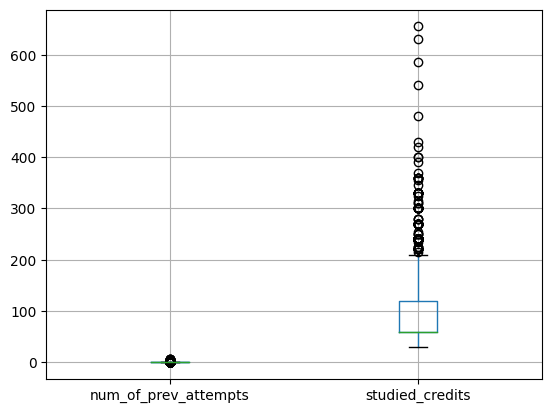

In [53]:
csv_basics(students, exclude_columns="id_student")

## registrations

~~TODO: investigate registration dates.~~
Why do 45 not have a registration date?
Unregistered before registered?
Unregistration - probably fine to leave, unless transform to - current, withdrawn, finished, or similar.

~~TODO: drop 45 without registration date~~

~~TODO: decide if removing unregistered before registered (on the day) or + 14 day cool off period (445 students) - probably this.~~



Since taking a break...I have had many thoughts about the data - especially around time:
* what is known when
* when it is useful to know something
* what data should be removed
* that there should be several predictions over the course of a module's duration -
    * assumption is that accuracy of prediction increases
    * also population needs to change - so students who have withdrawn before the prediction point are removed (their outcome is known)
* this will address:
    * identifying early withdrawals
    * those unlikely to continue
    * those who are struggling


This means that I need to think differently about how the data is prepared.


Number of rows: 32593 

Number of columns: 4 

Missing values:
 code_module                0
code_presentation          0
date_registration         45
date_unregistration    22521
dtype: int64 

Summary statistics:
        date_registration  date_unregistration
count       32548.000000         10072.000000
mean          -69.411300            49.757645
std            49.260522            82.460890
min          -322.000000          -365.000000
25%          -100.000000            -2.000000
50%           -57.000000            27.000000
75%           -29.000000           109.000000
max           167.000000           444.000000 



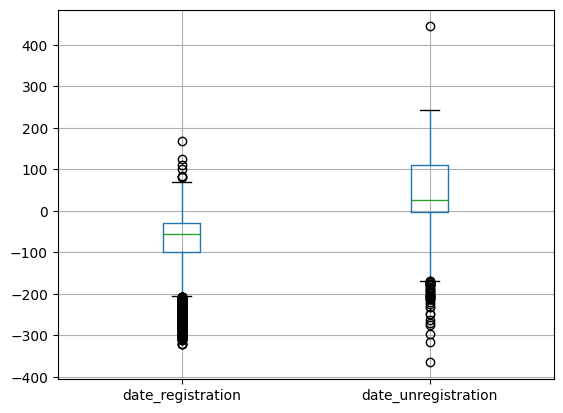

In [54]:
csv_basics(registrations, exclude_columns="id_student")

In [66]:


# unregistration before or on the same day as registration
registrations['unregistration_before_registration'] = registrations['date_unregistration'] <= registrations['date_registration']

# print unreg <= reg rows
unreg_before_reg = registrations[registrations['unregistration_before_registration'] == True]
#print(unreg_before_reg.head(20))

# unregistration before registration date + 14 (two weeks cool off)
registrations['unregistration_before_registration_14_days'] = registrations['date_unregistration'] <= registrations['date_registration'] + 14

# print unreg <= reg rows
unreg_before_reg_14_days = registrations[registrations['unregistration_before_registration_14_days'] == True]
#print(unreg_before_reg_14_days.head(20))
print(unreg_before_reg_14_days.count())

code_module                                   447
code_presentation                             447
id_student                                    447
date_registration                             447
date_unregistration                           447
unregistration_before_registration            447
unregistration_before_registration_14_days    447
dtype: int64


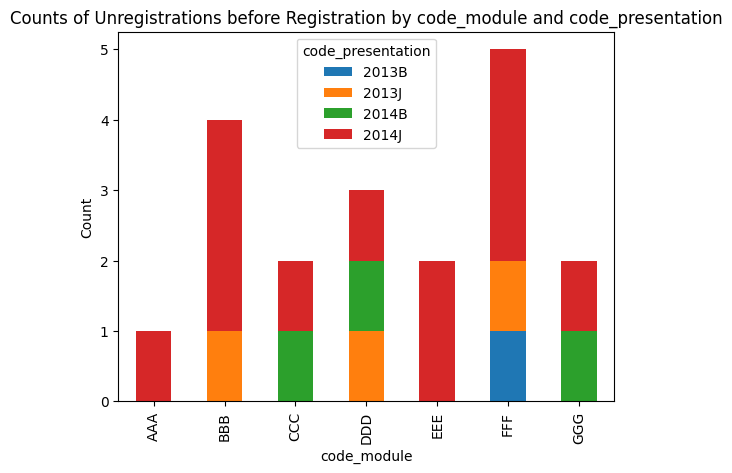

In [63]:
import matplotlib.pyplot as plt

# group  data by code_module and code_presentation, calculate the counts
grouped_counts = unreg_before_reg.groupby(['code_module', 'code_presentation']).size().unstack()

# grouped bar plot
grouped_counts.plot(kind='bar', stacked=True)
plt.xlabel('code_module')
plt.ylabel('Count')
plt.title('Counts of Unregistrations before Registration by code_module and code_presentation')
plt.legend(title='code_presentation')
plt.show()


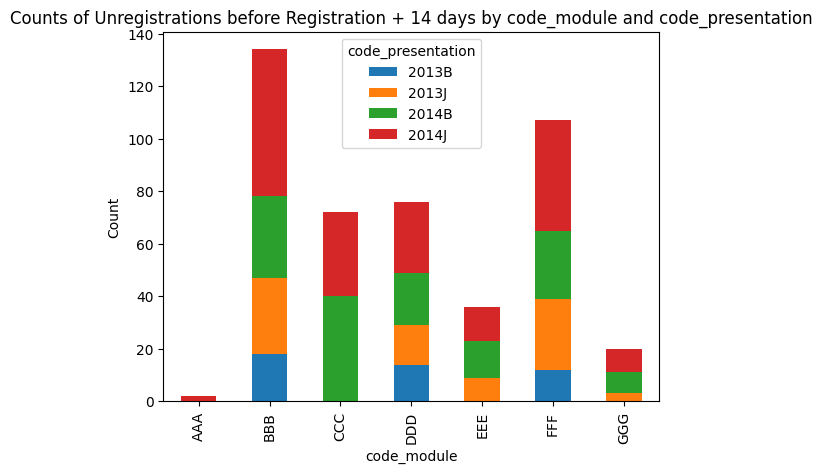

In [67]:
import matplotlib.pyplot as plt

# group  data by code_module and code_presentation, calculate the counts
grouped_counts = unreg_before_reg_14_days.groupby(['code_module', 'code_presentation']).size().unstack()

# grouped bar plot
grouped_counts.plot(kind='bar', stacked=True)
plt.xlabel('code_module')
plt.ylabel('Count')
plt.title('Counts of Unregistrations before Registration + 14 days by code_module and code_presentation')
plt.legend(title='code_presentation')
plt.show()

**Decision** exclude 445 rows of unreg within reg + 14 days 

So far: 

* students -> drop imd_cat missing 
* add reg date column, but exclude rows where unreg <= reg + 14 days and datereg missing

**Review!!** - may be keeping these in the dataset after all, and have several prediction points.  It would be useful to id these students early on, for example.


## courses

keep presentation length
add module name
split intake and year

Number of rows: 22 

Number of columns: 3 

Missing values:
 code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64 

Summary statistics:
        module_presentation_length
count                   22.000000
mean                   255.545455
std                     13.654677
min                    234.000000
25%                    241.000000
50%                    261.500000
75%                    268.000000
max                    269.000000 



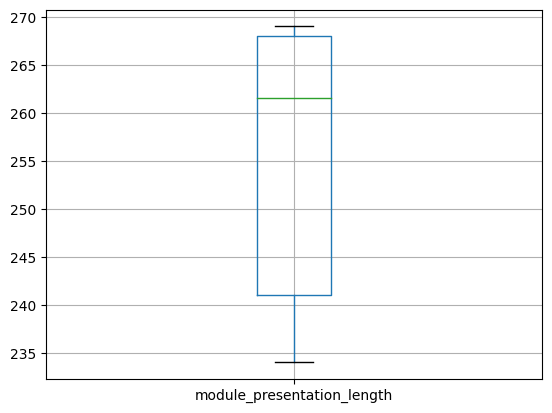

   code_module code_presentation  module_presentation_length
0          AAA             2013J                         268
1          AAA             2014J                         269
2          BBB             2013J                         268
3          BBB             2014J                         262
4          BBB             2013B                         240
5          BBB             2014B                         234
6          CCC             2014J                         269
7          CCC             2014B                         241
8          DDD             2013J                         261
9          DDD             2014J                         262
10         DDD             2013B                         240
11         DDD             2014B                         241
12         EEE             2013J                         268
13         EEE             2014J                         269
14         EEE             2014B                         241
15         FFF          

In [7]:
csv_basics(courses)
print(courses)

In [9]:


# split code_presentation into year and intake columns
registrations['year'] = registrations['code_presentation'].str[:4].astype(int)
registrations['intake'] = registrations['code_presentation'].str[-1].map({'J': 'Oct', 'B': 'Feb'})


# module subject mapping
code_module_mapping = {
    'AAA': 'SocSci',
    'BBB': 'SocSci',
    'GGG': 'SocSci',
    'CCC': 'Stem',
    'DDD': 'Stem',
    'EEE': 'Stem',
    'FFF': 'Stem'
}
registrations['module_category'] = registrations['code_module'].map(code_module_mapping)

# print
print(registrations[['code_module', 'code_presentation', 'year', 'intake', 'module_category']])


      code_module code_presentation  year intake module_category
0             AAA             2013J  2013    Oct          SocSci
1             AAA             2013J  2013    Oct          SocSci
2             AAA             2013J  2013    Oct          SocSci
3             AAA             2013J  2013    Oct          SocSci
4             AAA             2013J  2013    Oct          SocSci
...           ...               ...   ...    ...             ...
32588         GGG             2014J  2014    Oct          SocSci
32589         GGG             2014J  2014    Oct          SocSci
32590         GGG             2014J  2014    Oct          SocSci
32591         GGG             2014J  2014    Oct          SocSci
32592         GGG             2014J  2014    Oct          SocSci

[32593 rows x 5 columns]


## assessments

My first thought was to not include these, but actually they are critical as engagement data.
* need to work out how to use this 'in time' with registration/unregistration


TODO add course length -7 to missing date value (as per documentation - if date is missing then it was in the final week of the module.)

Number of rows: 206 

Number of columns: 5 

Missing values:
 code_module          0
code_presentation    0
assessment_type      0
date                 0
weight               0
dtype: int64 

Summary statistics:
              date      weight
count  206.000000  206.000000
mean   150.805825   20.873786
std     77.946393   30.384224
min     12.000000    0.000000
25%     81.250000    0.000000
50%    159.000000   12.500000
75%    227.000000   24.250000
max    266.000000  100.000000 



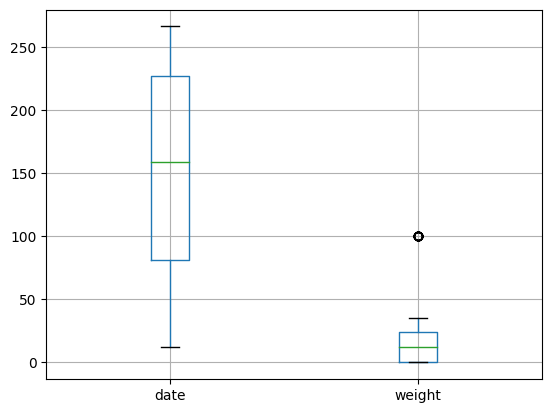

In [32]:
#csv_basics(assessments, exclude_columns="id_assessment")


# merge 'assessments' and 'courses' on 'code_module' and 'code_presentation'
merged_assess = assessments.merge(courses[['code_module', 'code_presentation', 'module_presentation_length']], on=['code_module', 'code_presentation'], how='left')

# value to fill in the missing 'date' values
value_to_fill = merged_assess['module_presentation_length'] - 3

# missing values in 'date' column 
merged_assess['date'] = merged_assess['date'].fillna(value_to_fill)

# Update 'assessments' DataFrame with the filled 'date' column
assessments['date'] = merged_assess['date']




csv_basics(assessments, exclude_columns="id_assessment")


In [33]:


# Define the desired 'id_assessment' numbers
desired_ids = [24290, 24299, 25368]

# Filter the rows with the desired 'id_assessment' numbers and display the 'date' column
filtered_assessments = assessments.loc[assessments['id_assessment'].isin(desired_ids), ['id_assessment', 'date']]

print(filtered_assessments)


     id_assessment   date
62           24290  238.0
72           24299  266.0
108          25368  259.0


Looking at date ranges - I wonder if I can engineer features, which look at submissions against expected submissions for intervals in for length of module.  

In [21]:
# group by 'code_module' and 'code_presentation' and counting unique 'id_assessment'
counts = assessments.groupby(['code_module','code_presentation' ])['id_assessment'].nunique()

print(counts)


code_module  code_presentation
AAA          2013J                 6
             2014J                 6
BBB          2013B                12
             2013J                12
             2014B                12
             2014J                 6
CCC          2014B                10
             2014J                10
DDD          2013B                14
             2013J                 7
             2014B                 7
             2014J                 7
EEE          2013J                 5
             2014B                 5
             2014J                 5
FFF          2013B                13
             2013J                13
             2014B                13
             2014J                13
GGG          2013J                10
             2014B                10
             2014J                10
Name: id_assessment, dtype: int64


## student assessments

What to do with missing scores?
Probably delete in the first model

TODO.

Remove is_banked from final table



In [76]:
print(student_assessments.head(20))

#csv_basics(student_assessments, exclude_columns="id_assessment")

    id_assessment  id_student  date_submitted  is_banked  score
0            1752       11391              18          0   78.0
1            1752       28400              22          0   70.0
2            1752       31604              17          0   72.0
3            1752       32885              26          0   69.0
4            1752       38053              19          0   79.0
5            1752       45462              20          0   70.0
6            1752       45642              18          0   72.0
7            1752       52130              19          0   72.0
8            1752       53025               9          0   71.0
9            1752       57506              18          0   68.0
10           1752       58873              19          0   73.0
11           1752       59185              18          0   67.0
12           1752       62155              17          0   73.0
13           1752       63400              19          0   83.0
14           1752       65002           

Number of rows: 173912 

Number of columns: 3 

Missing values:
 date_submitted      0
is_banked           0
score             173
dtype: int64 

Summary statistics:
        date_submitted      is_banked          score
count   173912.000000  173912.000000  173739.000000
mean       116.032942       0.010977      75.799573
std         71.484148       0.104194      18.798107
min        -11.000000       0.000000       0.000000
25%         51.000000       0.000000      65.000000
50%        116.000000       0.000000      80.000000
75%        173.000000       0.000000      90.000000
max        608.000000       1.000000     100.000000 



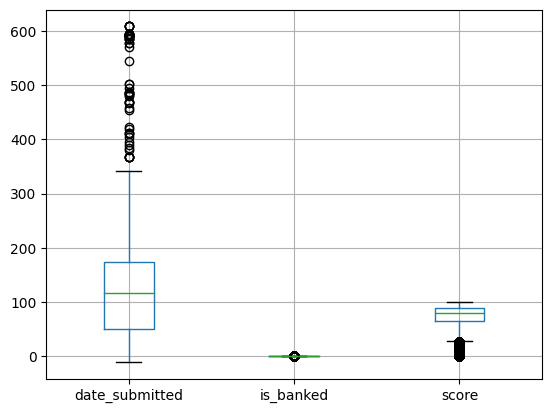

In [25]:
csv_basics(student_assessments, exclude_columns= ["id_assessment", "id_student"])

been thinking more about assessments...

For **version 1** of the model, I will look at creating the same feature out of assessments for each module - so that all modules share the same assessment profile. 



However, for **version 2** of the model, I will look at creating a feature for each module - so that each module has its own assessment profile.  I feel that there is a lot which is lost by aggregating assessments so that modules are comparable, but it complicates matters. 

Number of rows: 173912 

Number of columns: 8 

Missing values:
 date_submitted         0
is_banked              0
score                173
code_module            0
code_presentation      0
assessment_type        0
date                   0
weight                 0
dtype: int64 

Summary statistics:
        date_submitted      is_banked          score           date  \
count   173912.000000  173912.000000  173739.000000  173912.000000   
mean       116.032942       0.010977      75.799573     132.677584   
std         71.484148       0.104194      18.798107      79.031959   
min        -11.000000       0.000000       0.000000      12.000000   
25%         51.000000       0.000000      65.000000      54.000000   
50%        116.000000       0.000000      80.000000     131.000000   
75%        173.000000       0.000000      90.000000     222.000000   
max        608.000000       1.000000     100.000000     266.000000   

              weight  
count  173912.000000  
mean       12.743899  

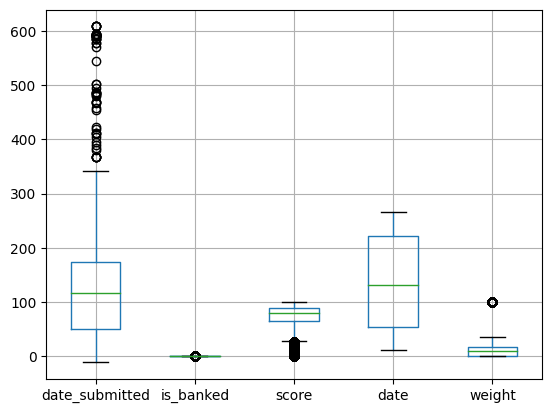

In [34]:
assessments_combined = pd.merge(student_assessments, assessments, on= 'id_assessment')
#print(assessments_combined.head(20))
csv_basics(assessments_combined, exclude_columns= ["id_assessment", "id_student"])

        date_submitted   date  date_diff
0                   18   19.0        1.0
1                   22   19.0       -3.0
2                   17   19.0        2.0
3                   26   19.0       -7.0
4                   19   19.0        0.0
...                ...    ...        ...
173907             227  229.0        2.0
173908             229  229.0        0.0
173909             215  229.0       14.0
173910             230  229.0       -1.0
173911             224  229.0        5.0

[173912 rows x 3 columns]


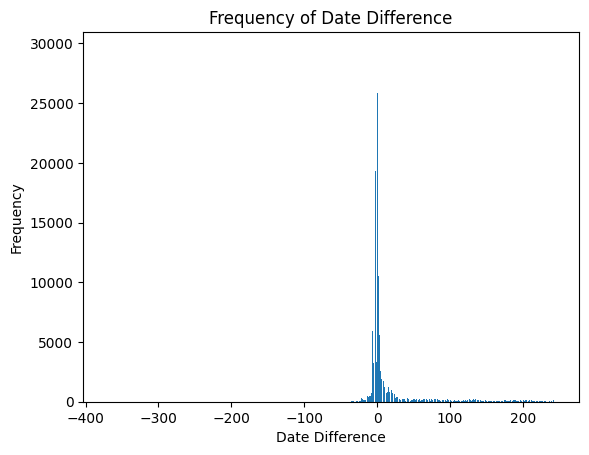

        date_submitted   date  date_diff
46                  54   19.0      -35.0
153                 58   19.0      -39.0
230                 50   19.0      -31.0
375                106   54.0      -52.0
492                 95   54.0      -41.0
...                ...    ...        ...
173557             198  229.0       31.0
173562             198  229.0       31.0
173563             203  229.0       26.0
173566             200  229.0       29.0
173567             207  229.0       22.0

[29862 rows x 3 columns]
       date_submitted          date     date_diff
count    29862.000000  29862.000000  29862.000000
mean       126.529770    220.119483     93.589713
std         72.772243     45.260513     69.230342
min        -11.000000     12.000000   -372.000000
25%         65.000000    222.000000     36.000000
50%        139.000000    229.000000     79.000000
75%        186.000000    236.000000    142.000000
max        608.000000    266.000000    246.000000


In [88]:
## dates details

# new df with date columns
new_df = assessments_combined[['date_submitted', 'date']].copy()

#  date difference column
new_df['date_diff'] = new_df['date'] - new_df['date_submitted']

# print
print(new_df)

# frequency table 
frequency_table = new_df['date_diff'].value_counts()

# plot the frequencies
plt.bar(frequency_table.index, frequency_table.values)

#  labels and title
plt.xlabel('Date Difference')
plt.ylabel('Frequency')
plt.title('Frequency of Date Difference')

# plot
plt.show()

# filter on the absolute difference (21 days)
filtered_df = new_df[abs(new_df['date_diff']) > 21]

# print
print(filtered_df)

print(filtered_df.describe())


In [79]:
print(student_assessments.head(20))
print(student_assessments[student_assessments['id_student'] == 65002])

    id_assessment  id_student  date_submitted  is_banked  score
0            1752       11391              18          0   78.0
1            1752       28400              22          0   70.0
2            1752       31604              17          0   72.0
3            1752       32885              26          0   69.0
4            1752       38053              19          0   79.0
5            1752       45462              20          0   70.0
6            1752       45642              18          0   72.0
7            1752       52130              19          0   72.0
8            1752       53025               9          0   71.0
9            1752       57506              18          0   68.0
10           1752       58873              19          0   73.0
11           1752       59185              18          0   67.0
12           1752       62155              17          0   73.0
13           1752       63400              19          0   83.0
14           1752       65002           

In [80]:

# Specify the date ranges for each assessment period
range1_start = 0
range1_end = 30
range2_start = 31
range2_end = 60
range3_start = 61
range3_end = 120
range4_start = 121
range4_end = 180
range5_start = 181
range5_end = 365

# Filter the student assessments based on the student ID
student_row = student_assessments[student_assessments['id_student'] == 65002]

# Calculate the submission count within each date range
count_range1 = student_row[(student_row['date_submitted'] >= range1_start) & (student_row['date_submitted'] <= range1_end)].shape[0]
count_range2 = student_row[(student_row['date_submitted'] >= range2_start) & (student_row['date_submitted'] <= range2_end)].shape[0]
count_range3 = student_row[(student_row['date_submitted'] >= range3_start) & (student_row['date_submitted'] <= range3_end)].shape[0]
count_range4 = student_row[(student_row['date_submitted'] >= range4_start) & (student_row['date_submitted'] <= range4_end)].shape[0]
count_range5 = student_row[(student_row['date_submitted'] >= range5_start) & (student_row['date_submitted'] <= range5_end)].shape[0]

# Print the submission counts for each assessment period
print("Submission Count within Date Range 1:", count_range1)
print("Submission Count within Date Range 2:", count_range2)
print("Submission Count within Date Range 3:", count_range3)
print("Submission Count within Date Range 4:", count_range4)
print("Submission Count within Date Range 5:", count_range5)






Submission Count within Date Range 1: 1
Submission Count within Date Range 2: 1
Submission Count within Date Range 3: 0
Submission Count within Date Range 4: 0
Submission Count within Date Range 5: 0


In [93]:
# Merge 'student_assessments' with 'courses' to get the course length
merged_data = assessments_combined.merge(courses[['code_module', 'code_presentation', 'module_presentation_length']], 
                                       on=['code_module', 'code_presentation'], how='left')

# Calculate the maximum allowed date based on course length
merged_data['max_allowed_date'] = merged_data['module_presentation_length'] + 5

# Count the number of negative date_submitted values
count_negative_dates = merged_data[merged_data['date_submitted'] < 0].shape[0]

# Count the number of date_submitted values that are significantly larger than the due date
count_large_dates = merged_data[merged_data['date_submitted'] > merged_data['max_allowed_date']].shape[0]

# Print the counts
print("Count of Negative date_submitted values:", count_negative_dates)
print("Count of date_submitted values significantly larger than the due date:", count_large_dates)




Count of Negative date_submitted values: 2057
Count of date_submitted values significantly larger than the due date: 77


In [28]:
## fixed

# Filter the rows with missing 'date'
#missing_date_rows = assessments_combined[assessments_combined['date'].isnull()]

# Group the filtered rows by 'code_module' and 'code_presentation'
#grouped_missing_date = missing_date_rows.groupby(['code_module', 'code_presentation', 'id_assessment'])

#print(grouped_missing_date.size())


code_module  code_presentation  id_assessment
CCC          2014B              24290             747
             2014J              24299            1168
DDD          2014J              25368             950
dtype: int64


Combined code below - tested but can be optimised and improved.

In [21]:
## to be made into a function?? with a prediction point splitter??

# step 1 merge 'student' with 'course'
final_student = pd.merge(students, courses, on=['code_module', 'code_presentation'], validate='many_to_one')
final_student.head()

# step 2 merge registrations with final_student
final_student = pd.merge(final_student, registrations, on=['code_module','code_presentation','id_student'], validate="1:1")

# step 3 drop imd_band, date_reg nulls and replace NaN for unreg date with the length of the course
final_student.dropna(subset=['date_registration', 'imd_band'], inplace=True)
final_student['date_unregistration'] = final_student['date_unregistration'].fillna(final_student['module_presentation_length'])

# step 4 drop rows where withdrew before started - may want to add cool off buffer 7-14 days? (as earlier)
final_student = final_student[final_student['date_unregistration'] < final_student['date_registration']]

# step 5 split code_presentation into year and month and add subject from code_module
final_student['year'] = final_student['code_presentation'].str[:4].astype(int)
final_student['month'] = final_student['code_presentation'].str[-1].map({'J': 'Oct', 'B': 'Feb'})

# Module subject mapping
code_module_mapping = {
    'AAA': 'SocSci',
    'BBB': 'SocSci',
    'GGG': 'SocSci',
    'CCC': 'Stem',
    'DDD': 'Stem',
    'EEE': 'Stem',
    'FFF': 'Stem'
}
final_student['subject'] = final_student['code_module'].map(code_module_mapping)

#final_student.head()

# step 6 prep assessments - fill missing dates with length of course - 3 days (last week of course)

# merge 'assessments' and 'courses' on 'code_module' and 'code_presentation'
merged_assess = assessments.merge(courses[['code_module', 'code_presentation', 'module_presentation_length']], on=['code_module', 'code_presentation'], how='left')

# value to fill in the missing 'date' values
value_to_fill = merged_assess['module_presentation_length'] - 3

# missing values in 'date' column 
merged_assess['date'] = merged_assess['date'].fillna(value_to_fill)

# update 'assessments' with filled 'date' column
assessments['date'] = merged_assess['date']


# step 7 merge assessments with final_student

## remove cols - is_banked, score = null


# Data Plan

students
- drop `imd_cat` missing
course
- prep as above
- merge with course on code_module, code_presentation
registrations
- merge with student
- drop where unreg before or = reg

TODO: work out what to do with dates

Data TODO list: 

* build dataset
~~student~~
~~registration~~
~~course~~
assessment
vle
* clean dataset
* create function which splits dataset based on date - > this is why unreg_date must equal length of course.

In [ ]:
, skiprows=[128223,64073]